In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

dias_habiles_por_año = 252
start_date = "2020-01-02"
end_date = "2024-01-30"
# portfolio = [
#     "GFNORTEO.MX",
#     "AC.MX",
#     "PINFRA.MX",
#     "GAPB.MX",
#     "GENTERA.MX",
#     "TLEVISACPO.MX",
#     "GCARSOA1.MX",
#     "GCC.MX",
#     "MEGACPO.MX",
#     "BIMBOA.MX",
# ]
portfolio = [
    "GCARSOA1.MX",
    "BIMBOA.MX",
]

tlr=0.1125

In [125]:


# Restricción máxima de activos en portafolio:
if len(portfolio) > 10:
    raise Exception("El número máximo de activos en el portafolio es de 10")
else:
    # Se cumple la restricción:

    precios_diarios = pd.DataFrame()
    rendimientos_diarios = pd.DataFrame()

    for x in portfolio:
        stock = yf.Ticker(x)
        close_price = stock.history(start=start_date, end=end_date)["Close"]

        # Se insertan datos en precios_diarios y rendimientos_diarios
        precios_diarios = pd.concat([precios_diarios, close_price], axis=1)
        # Con pct_change() obtenemos los rendimientos (cambio porcentual)
        rendimientos_diarios = pd.concat([rendimientos_diarios, close_price.pct_change()], axis=1)

# Asignamos nombre de acciones a las columnas de cada DataFrame

precios_diarios.columns = portfolio
rendimientos_diarios.columns = portfolio

# Eliminamos valores nulos de las columnas con dropna()
# (El primer valor de rendimiento es nulo)

rendimientos_diarios = rendimientos_diarios.dropna()

# Ver los datos generados:
print("Precios diarios  "+start_date+"  Hasta  "+end_date)
display(precios_diarios)
print("Rendimientos diarios  "+start_date+"Hasta  "+end_date)
display(rendimientos_diarios)
# Ejecutamos

Precios diarios  2020-01-02  Hasta  2024-01-30


,GCARSOA1.MX,BIMBOA.MX
2020-01-02 00:00:00-06:00,70.133469,33.092861
2020-01-03 00:00:00-06:00,70.541603,33.102219
2020-01-06 00:00:00-06:00,70.888039,33.247284
2020-01-07 00:00:00-06:00,69.620911,32.802734
2020-01-08 00:00:00-06:00,70.152451,32.774662
...,...,...
2024-01-23 00:00:00-06:00,158.929993,78.059998
2024-01-24 00:00:00-06:00,163.029999,77.400002
2024-01-25 00:00:00-06:00,161.470001,76.940002
2024-01-26 00:00:00-06:00,165.550003,79.040001


Rendimientos diarios  2020-01-02Hasta  2024-01-30


,GCARSOA1.MX,BIMBOA.MX
2020-01-03 00:00:00-06:00,0.005819,0.000283
2020-01-06 00:00:00-06:00,0.004911,0.004382
2020-01-07 00:00:00-06:00,-0.017875,-0.013371
2020-01-08 00:00:00-06:00,0.007635,-0.000856
2020-01-09 00:00:00-06:00,0.000270,0.023130
...,...,...
2024-01-23 00:00:00-06:00,0.036252,-0.003192
2024-01-24 00:00:00-06:00,0.025798,-0.008455
2024-01-25 00:00:00-06:00,-0.009569,-0.005943
2024-01-26 00:00:00-06:00,0.025268,0.027294


In [139]:


rendimientos_esperados = rendimientos_diarios.mean() * dias_habiles_por_año * 100
riesgo_individual = rendimientos_diarios.std() * np.sqrt(dias_habiles_por_año) * 100
# Ver datos generados:
print("Rendimientos esperados anualizado")
print(rendimientos_esperados)
print("Riesgo anualizado")
print(riesgo_individual)

Rendimientos esperados anualizado
GCARSOA1.MX    29.362738
BIMBOA.MX      27.547525
dtype: float64
Riesgo anualizado
GCARSOA1.MX    39.821314
BIMBOA.MX      34.810050
dtype: float64


In [127]:
# Calcular la matriz de covarianza de los rendimientos diarios
matriz_covarianza = rendimientos_diarios.cov()

# Imprimir o utilizar la matriz de covarianza según sea necesario
matriz_covarianza

,GCARSOA1.MX,BIMBOA.MX
GCARSOA1.MX,0.000629,0.000186
BIMBOA.MX,0.000186,0.000481


In [128]:
# Crear DataFrame de ejemplo (reemplaza esto con tus propios datos)
data = {'Empresa': portfolio}
df_portfolio = pd.DataFrame(data)


# Agregar también la proporción subóptima al DataFrame original
df_portfolio['Peso'] = 1/len(portfolio)

# Ver los datos generados:
print('DataFrame con portafolio subóptimo y proporción subóptima:')
df_portfolio=df_portfolio.set_index("Empresa")

DataFrame con portafolio subóptimo y proporción subóptima:


In [129]:
# Calcular la varianza del portafolio en Python
def varianza_portafolio(portafolio,covarianza):
    varianza= portafolio.T @ covarianza @ portafolio
    return varianza.values[0, 0]

def rend_portafolio(peso,rendimientos):
    suma_producto= peso @ rendimientos
    return suma_producto

def riesgo_portafolio(varianza,dias):
    riesgo= np.sqrt(varianza)*np.sqrt(dias)
    return riesgo

In [130]:
# Varianza del portafolio subóptimo
var_portafolio = varianza_portafolio(df_portfolio,matriz_covarianza)


# Rendimiento esperado del portafolio subóptimo
rendimiento_esperado_portafolio = rend_portafolio(df_portfolio["Peso"].astype(float),rendimientos_esperados)/100


# Riesgo del portafolio subóptimo
risk_portafolio = riesgo_portafolio(var_portafolio,252)

indice_sharp=(rendimiento_esperado_portafolio-tlr)/risk_portafolio

# Ver datos generados:
print('Portafolio subóptimo')
print(f'Rendimiento esperado: {rendimiento_esperado_portafolio*100}')
print(f'Riesgo: {risk_portafolio*100}')
print(f'Varianza: {var_portafolio}')
print(f'Indice_Sharp: {indice_sharp*100}')
# 


Portafolio subóptimo
Rendimiento esperado: 28.455131301195053
Riesgo: 30.559590530228597
Varianza: 0.00037059070372033224
Indice_Sharp: 56.30026778067027


In [131]:
def funcion_riesgo(pesos, matriz_covarianza, dias):
    varianza = np.dot(np.dot(pesos, matriz_covarianza), pesos)
    riesgo = np.sqrt(varianza) * np.sqrt(dias)
    return riesgo

restricciones = [
    {'type': 'eq', 'fun': lambda pesos: sum(pesos) - 1},
]

# Inicialización de pesos
pesos_iniciales = np.ones(len(portfolio)) / len(portfolio)

# Optimización
resultado = minimize(funcion_riesgo, pesos_iniciales, args=(matriz_covarianza, dias_habiles_por_año),
                     constraints=restricciones)

# Obtener los pesos óptimos del portafolio
pesos_optimos = resultado.x

df_portfolio['Peso_Optimo'] = pesos_optimos
df_portfolio


,Peso,Peso_Optimo
Empresa,,
GCARSOA1.MX,0.5,0.398212
BIMBOA.MX,0.5,0.601788


In [132]:
df_portfolio_optimo = df_portfolio.drop('Peso', axis=1)

# Varianza del portafolio subóptimo
var_portafolio_optimo = varianza_portafolio(df_portfolio_optimo,matriz_covarianza)


# Rendimiento esperado del portafolio subóptimo
rendimiento_esperado_portafolio_optimo = rend_portafolio(df_portfolio["Peso_Optimo"].astype(float),rendimientos_esperados)/100


# Riesgo del portafolio subóptimo
risk_portafolio_optimo = riesgo_portafolio(var_portafolio_optimo,252)

indice_sharp_optimo=(rendimiento_esperado_portafolio_optimo-tlr)/risk_portafolio_optimo

# Ver datos generados:
print('Portafolio optimo')
print(f'Rendimiento esperado: {rendimiento_esperado_portafolio_optimo*100}')
print(f'Riesgo: {risk_portafolio_optimo*100}')
print(f'Varianza: {var_portafolio_optimo}')
print(f'Indice_Sharp: {indice_sharp_optimo*100}')
# 

Portafolio optimo
Rendimiento esperado: 28.270364134215566
Riesgo: 30.250371536700964
Varianza: 0.0003631289595668444
Indice_Sharp: 56.26497550142741


MAXIMIZANDO EL PORTAFOLIO CONSIDERANDO EL INDICE SHARP

In [133]:
def funcion_riesgo(pesos, rendimientos, matriz_covarianza, tlr, dias):
    rendimiento_portafolio = np.dot(rendimientos, pesos)
    varianza = np.dot(np.dot(pesos, matriz_covarianza), pesos)
    riesgo = np.sqrt(varianza) * np.sqrt(dias)
    indice_sharp = (rendimiento_portafolio - tlr) / riesgo
    # Se devuelve el negativo del índice de Sharpe para maximizarlo
    return -indice_sharp

restricciones = [
    {'type': 'eq', 'fun': lambda pesos: sum(pesos) - 1},
]

# Inicialización de pesos
pesos_iniciales = np.ones(len(portfolio)) / len(portfolio)

# Optimización
resultado = minimize(funcion_riesgo, pesos_iniciales, args=(rendimientos_esperados, matriz_covarianza, tlr, dias_habiles_por_año),
                     constraints=restricciones)

# Obtener los pesos óptimos del portafolio
pesos_optimos = resultado.x

df_portfolio['Peso_Optimo'] = pesos_optimos
df_portfolio


,Peso,Peso_Optimo
Empresa,,
GCARSOA1.MX,0.5,0.431141
BIMBOA.MX,0.5,0.568859


In [134]:
df_portfolio_sharpe = df_portfolio.drop('Peso', axis=1)

# Varianza del portafolio subóptimo
var_portafolio_sharpe = varianza_portafolio(df_portfolio_sharpe,matriz_covarianza)


# Rendimiento esperado del portafolio subóptimo
rendimiento_esperado_portafolio_sharpe = rend_portafolio(df_portfolio_sharpe["Peso_Optimo"].astype(float),rendimientos_esperados)/100


# Riesgo del portafolio subóptimo
risk_portafolio_sharpe = riesgo_portafolio(var_portafolio_sharpe,252)

indice_sharp_port=(rendimiento_esperado_portafolio-tlr)/risk_portafolio_optimo

# Ver datos generados:
print('Portafolio optimo Sharpe')
print(f'Rendimiento esperado: {rendimiento_esperado_portafolio_optimo*100}')
print(f'Riesgo: {risk_portafolio_sharpe*100}')
print(f'Varianza: {var_portafolio_sharpe}')
print(f'Indice_Sharp: {indice_sharp_port*100}')
# 

Portafolio optimo Sharpe
Rendimiento esperado: 28.270364134215566
Riesgo: 30.281214380051637
Varianza: 0.0003638698191788278
Indice_Sharp: 56.87576855154026


In [135]:
num_portafolios=40

riesgos_grafica=[]
rendimiento_grafica=[]

for i in range(18,num_portafolios + 1):
    rendimiento_resultado= (tlr+indice_sharp_port*(i/100))*100
    riesgos_grafica.append(i)
    rendimiento_grafica.append(rendimiento_resultado)


rendimiento_grafica

[21.487638339277247,
 22.05639602479265,
 22.625153710308055,
 23.193911395823456,
 23.76266908133886,
 24.331426766854264,
 24.90018445236966,
 25.468942137885065,
 26.037699823400466,
 26.60645750891587,
 27.175215194431274,
 27.743972879946675,
 28.31273056546208,
 28.881488250977483,
 29.450245936492887,
 30.019003622008288,
 30.587761307523692,
 31.15651899303909,
 31.725276678554494,
 32.294034364069894,
 32.8627920495853,
 33.4315497351007,
 34.0003074206161]

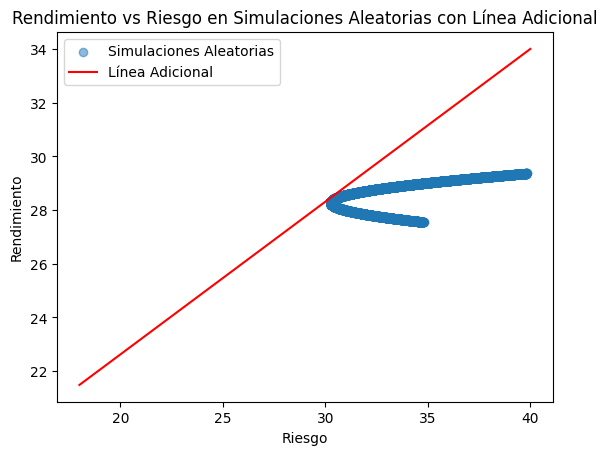

In [138]:
# Número de simulaciones
num_simulaciones = 10000

# Lista para almacenar los resultados de rendimiento y riesgo
rendimientos = []
riesgos = []

# Realiza simulaciones aleatorias
for _ in range(num_simulaciones):
    # Genera pesos aleatorios
    pesos_simulacion = np.random.rand(len(portfolio))
    pesos_simulacion /= np.sum(pesos_simulacion)  # Normaliza para asegurarse de que sumen 1
    # Calcula rendimiento y riesgo
    rendimiento = np.dot(pesos_simulacion, rendimientos_esperados)
    riesgo = np.sqrt(np.dot(np.dot(pesos_simulacion, matriz_covarianza), pesos_simulacion) * dias_habiles_por_año)*100

    # Almacena resultados
    rendimientos.append(rendimiento)
    riesgos.append(riesgo)

# Convierte las listas a arrays de NumPy para facilitar su manipulación
rendimientos = np.array(rendimientos)
riesgos = np.array(riesgos)

# Grafica el rendimiento vs riesgo
plt.scatter(riesgos, rendimientos, alpha=0.5, label='Simulaciones Aleatorias')  # Etiqueta para las simulaciones aleatorias
plt.plot(riesgos_grafica, rendimiento_grafica, color='red', label='Línea Adicional')  # Línea adicional en color rojo
plt.title('Rendimiento vs Riesgo en Simulaciones Aleatorias con Línea Adicional')
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento')
plt.legend()  # Muestra las leyendas
plt.show()